In [96]:
# A whole new big mess of a step...
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model running via: {device}")

Model running via: cuda


In [98]:
# Globally Shared Model(s) Parameters
num_epochs = 2500
hidden_dims = ([300, 300, 300, 300, 300, 300, 300])
LF_training_size = 62
HF_training_size = 42

# Synthetic data function
def LF(x):
    return torch.sin(x * (8 * np.pi))*x
    
def HF(x): 
    return 1.8*torch.sin(x * (8 * np.pi))*2*x 


# Run this through the model to get the black prediction line
# (predictionu bundan al)
Z = torch.linspace(0, 1, 1000)[:,None]

# Model's total training/val/testing dataset
LF_TS = torch.linspace(0, 1, LF_training_size)[:,None]
HF_TS = torch.linspace(0, 1, HF_training_size)[:,None]

# Forming LF Test Sets with a neat trick
Placeholder, X_LF_test, Place_holder, Y_LF_test = train_test_split(LF_TS, LF(LF_TS), test_size=0.7)
Placeholder, X_HF_test, Place_holder, Y_HF_test = train_test_split(HF_TS, HF(HF_TS), test_size=0.7)

# Forming the real equally spaced training sets
X_LF_train = LF_TS
Y_LF_train = LF(LF_TS) 

X_HF_train = HF_TS
Y_HF_train = HF(HF_TS)

# Transfering data to GPU for CUDA
X_LF_train = X_LF_train.to(device); Y_LF_train = Y_LF_train.to(device)
X_HF_train = X_HF_train.to(device); Y_HF_train = Y_HF_train.to(device)

X_LF_test = X_LF_test.to(device); Y_LF_test = Y_LF_test.to(device)
X_HF_test = X_HF_test.to(device); Y_HF_test = Y_HF_test.to(device)

Low Fidelity Network

In [99]:
LF_input_dim = 1
LF_output_dim = 1

class LowFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, LF_input_dim, LF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(LF_input_dim, hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc4 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fcEND = nn.Linear(hidden_dims[4], LF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = self.fcEND(x)
    return x

LF_model = LowFidelityNetwork(hidden_dims, LF_input_dim, LF_output_dim).to(device)

for param in LF_model.parameters():
    param.requires_grad = True

In [100]:
# Training
LF_losses = [] 
val_losses = []
prev_loss = []
LF_loss = torch.zeros(1)

LF_batch_size = 20

# LF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(LF_model.parameters(), lr=1e-4) # weight_decay=1e-5

for epoch in range(num_epochs):
    # Batches
    shuffled_indices = torch.randperm(X_LF_train.size(0))
    X_LF_train = X_LF_train[shuffled_indices]
    Y_LF_train = Y_LF_train[shuffled_indices]
    num_batches = X_LF_train.size(0) // LF_batch_size
    for batch in range(num_batches):
        start = batch * LF_batch_size
        end = start + LF_batch_size
        X_batch = X_LF_train[start:end]
        Y_batch = Y_LF_train[start:end]
    # Training
    prev_loss = LF_loss.item()
    y_pred = LF_model(X_LF_train.to(device))
    Y_LF_train = Y_LF_train.reshape(*X_LF_train.shape)
    LF_loss = criterion(y_pred, Y_LF_train.to(device))
    LF_losses.append(LF_loss.item())
    optimizer.zero_grad()
    LF_loss.backward()
    optimizer.step()


    # Validation
    shuffled_indices_val = torch.randperm(X_LF_test.size(0))
    X_LF_test = X_LF_test[shuffled_indices_val]
    Y_LF_test = Y_LF_test[shuffled_indices_val]
    num_batches_val = X_LF_test.size(0) // LF_batch_size
    for batch in range(num_batches_val):
        start = batch * LF_batch_size
        end = start + LF_batch_size
        X_batch = X_LF_test[start:end]
        Y_batch = Y_LF_test[start:end]
    # Training
    val_outputs = LF_model(X_LF_test)
    val_loss = criterion(val_outputs, Y_LF_test)
    val_losses.append(val_loss.item())

    current_loss = LF_loss.item()
    if abs(current_loss - prev_loss) < 1e-9:
        break

Error: 7.221064540743705
Epochs needed (out of 6000): 5164
LF Training Loss: 0.00010697109246393666


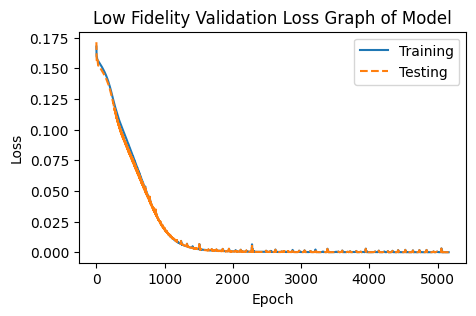

In [101]:
# Calculating Error of model via valiation set
percentage_errors = []

for i in range(len(LF_losses)):
    abs_error = ((abs(LF_losses[i] - val_losses[i]))/2)
    percentage_error = (abs_error / val_losses[i]) * 100
    percentage_errors.append(percentage_error)
LF_average_percentage_error = sum(percentage_errors) / len(percentage_errors)

plt.figure(figsize=(5,3))
plt.plot(LF_losses, label = "Training")
plt.xlabel('Epoch')
plt.ylabel('LF_Loss')
plt.title('Low Fidelity Training Loss Graph of Model')

plt.plot(val_losses, "--" , label = "Testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Low Fidelity Validation Loss Graph of Model')
plt.legend(loc='upper right')
# plt.show()

print(f"Error: {LF_average_percentage_error}")
print(f"Epochs needed (out of {num_epochs}): {len(LF_losses)}")
print(f"LF Training Loss: {LF_loss}")

High Fidelity Model

In [102]:
HF_input_dim = 1
HF_output_dim = 1

class HighFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, HF_input_dim, HF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(HF_input_dim, hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc4 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fcEND = nn.Linear(hidden_dims[4], HF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = self.fcEND(x)
    return x

HF_model = HighFidelityNetwork(hidden_dims, HF_input_dim, HF_output_dim).to(device)

for param in HF_model.parameters():
    param.requires_grad = True

In [103]:
# Training
HF_losses = [] 
val_losses = []
prev_loss = []
HF_loss = torch.zeros(1)

HF_batch_size = 20

# HF_loss criterion and optimizer
optimizer = torch.optim.Adam(HF_model.parameters(), lr=1e-4) # weight_decay=1e-5

for epoch in range(num_epochs):
    # Batches
    shuffled_indices = torch.randperm(X_HF_train.size(0))
    X_HF_train = X_HF_train[shuffled_indices]
    Y_HF_train = Y_HF_train[shuffled_indices]
    num_batches = X_HF_train.size(0) // HF_batch_size
    for batch in range(num_batches):
        start = batch * HF_batch_size
        end = start + HF_batch_size
        X_batch = X_HF_train[start:end]
        Y_batch = Y_HF_train[start:end]
    # Training
    prev_loss = HF_loss.item()
    y_pred = HF_model(X_HF_train.to(device))
    Y_HF_train = Y_HF_train.reshape(*X_HF_train.shape)
    HF_loss = criterion(y_pred, Y_HF_train.to(device))
    HF_losses.append(HF_loss.item())
    optimizer.zero_grad()
    HF_loss.backward()
    optimizer.step()


    # Validation
    shuffled_indices_val = torch.randperm(X_HF_test.size(0))
    X_HF_test = X_HF_test[shuffled_indices_val]
    Y_HF_test = Y_HF_test[shuffled_indices_val]
    num_batches_val = X_HF_test.size(0) // HF_batch_size
    for batch in range(num_batches_val):
        start = batch * HF_batch_size
        end = start + HF_batch_size
        X_batch = X_HF_test[start:end]
        Y_batch = Y_HF_test[start:end]
    # Training
    val_outputs = HF_model(X_HF_test)
    val_loss = criterion(val_outputs, Y_HF_test)
    val_losses.append(val_loss.item())

    current_loss = HF_loss.item()
    if abs(current_loss - prev_loss) < 1e-9:
        break

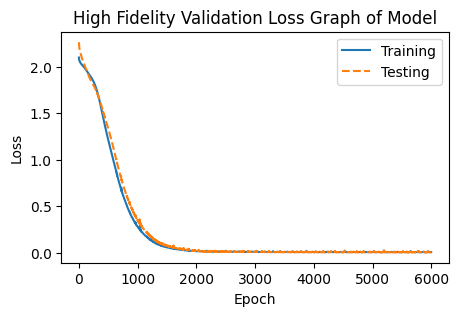

Error: 7.14827938370021
Epochs needed (out of 6000): 6000
HF Training Loss: 0.004867566283792257


In [104]:
# Calculating Error of model via valiation set
percentage_errors = []

for i in range(len(HF_losses)):
    abs_error = ((abs(HF_losses[i] - val_losses[i]))/2)
    percentage_error = (abs_error / val_losses[i]) * 100
    percentage_errors.append(percentage_error)
HF_average_percentage_error = sum(percentage_errors) / len(percentage_errors)

plt.figure(figsize=(5,3))
plt.plot(HF_losses, label = "Training")
plt.xlabel('Epoch')
plt.ylabel('LF_Loss')
plt.title('Low Fidelity Training Loss Graph of Model')

plt.plot(val_losses, "--" , label = "Testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('High Fidelity Validation Loss Graph of Model')
plt.legend(loc='upper right')
plt.show()

print(f"Error: {HF_average_percentage_error}")
print(f"Epochs needed (out of {num_epochs}): {len(HF_losses)}")
print(f"HF Training Loss: {HF_loss}")

Convolutional Data Reshaping

In [105]:
# Data Editing

# Since LF and HF data are not equal in length, to make vector calculations the missing points are replaced with zeros.
fidelity_len_diff = len(Y_LF_train)-len(Y_HF_train)
additional_len = torch.zeros(fidelity_len_diff)[:,None].to(device)
Y_HF_train = torch.vstack((Y_HF_train, additional_len))

# The convoltutional data input must be in [y_LF, LF_MODEL(LF), y_HF, LF_MODEL(HF)] format
conv_input = torch.hstack((Y_LF_train, LF_model(Y_LF_train), Y_HF_train, LF_model(Y_HF_train)))
print(conv_input.shape)

torch.Size([62, 4])


In [111]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 4), stride=1)

    def forward(self, x):
        x = x.unsqueeze(0) # add batch dimension
        x = x.unsqueeze(0) # add channel dimension
        x = self.conv(x)
        return x.squeeze(0) # remove batch and channel dimension

conv_model = ConvNet().to(device)
conv_output = conv_model(conv_input)
conv_output = conv_output.view(-1)[:,None]

print(conv_output.shape)
# Cut the length HF datapoints to the length of the conv_output
Y_HF_train_MFMODEL=  Y_HF_train[0:len(conv_output)]

torch.Size([60, 1])


Multi-Fidelity Model

In [107]:
MF_input_dim = 1
MF_output_dim = 1

class MultiFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, MF_input_dim, MF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(MF_input_dim, hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc4 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fcEND = nn.Linear(hidden_dims[4], MF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = self.fcEND(x)
    return x

MF_model = MultiFidelityNetwork(hidden_dims, MF_input_dim, MF_output_dim).to(device)

for param in MF_model.parameters():
    param.requires_grad = True

In [108]:
# Training
MF_losses = [] 
val_losses = []
prev_loss = []
MF_loss = torch.zeros(1)

# MF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(MF_model.parameters(), lr=1e-2) # weight_decay=1e-5

for epoch in range(num_epochs):
    # Training
    prev_loss = MF_loss.item()
    MF_y_pred = MF_model(conv_output)
    MF_loss = criterion(MF_y_pred, Y_HF_train_MFMODEL)
    MF_losses.append(MF_loss.item())
    optimizer.zero_grad()
    MF_loss.backward(retain_graph=True)
    optimizer.step()
    
    current_loss = MF_loss.item()
    if abs(current_loss - prev_loss) < 1e-9:
        break

MF Training Loss: 0.07383862882852554


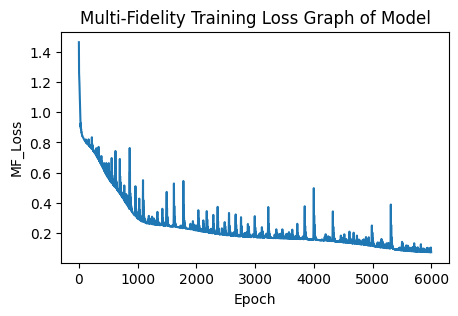

In [109]:
plt.figure(figsize=(5,3))
plt.plot(MF_losses)
plt.xlabel('Epoch')
plt.ylabel('MF_Loss')
plt.title('Multi-Fidelity Training Loss Graph of Model')
print(f"MF Training Loss: {MF_loss}")

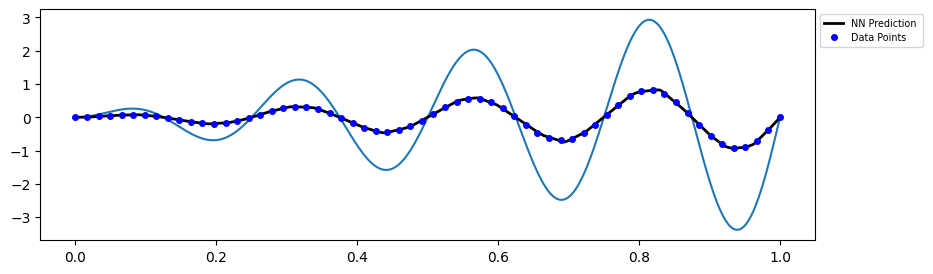

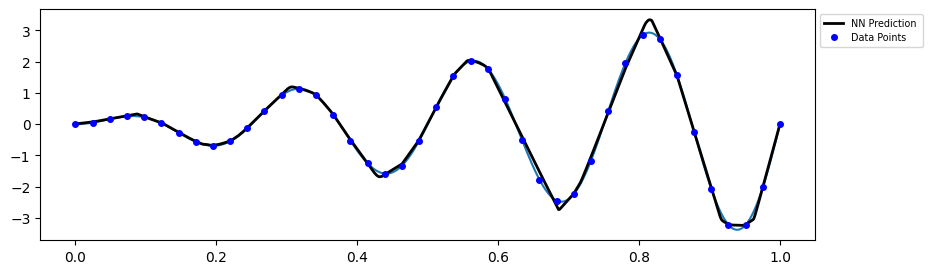

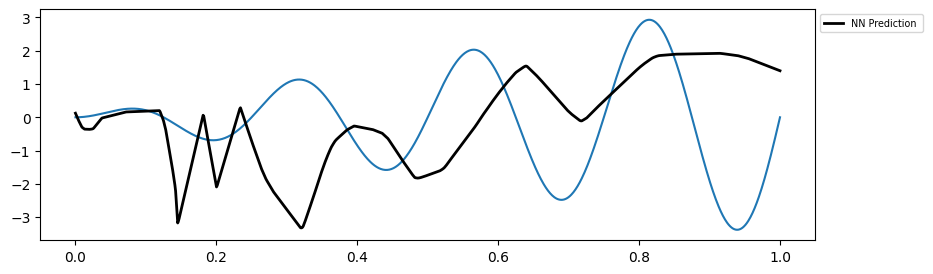

In [110]:
LF_model.eval()
HF_model.eval()
MF_model.eval()

for layer in LF_model.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        layer.eval()

# Define the NEW input data
with torch.no_grad(): 
    # Y_test_prediction = LF_model(X_LF_test.to(device)) # Testing Data
    y_LF_pred = LF_model(Z.to(device))
    y_HF_pred = HF_model(Z.to(device)) 
    y_MF_pred = MF_model(Z.to(device)) 


### Sonra düzeltirim
LF_TS = torch.linspace(0, 1, LF_training_size)[:,None]
HF_TS = torch.linspace(0, 1, HF_training_size)[:,None]
X_LF_train = LF_TS
Y_LF_train = LF(LF_TS) 

X_HF_train = HF_TS
Y_HF_train = HF(HF_TS)

# Transfering data to GPU for CUDA
X_LF_train = X_LF_train.to(device); Y_LF_train = Y_LF_train.to(device)
X_HF_train = X_HF_train.to(device); Y_HF_train = Y_HF_train.to(device)

X_LF_test = X_LF_test.to(device); Y_LF_test = Y_LF_test.to(device)
X_HF_test = X_HF_test.to(device); Y_HF_test = Y_HF_test.to(device)
###

# Low Fidelity Model
plt.figure(figsize=(10,3))
plt.plot(Z, HF(Z))
plt.plot(Z.cpu().detach().numpy(), y_LF_pred.cpu().detach().numpy(),'k', lw=2, label= "NN Prediction ")
plt.plot(X_LF_train.cpu().detach().numpy(), Y_LF_train.cpu().detach().numpy(), 'bo', markersize = 4, label = 'Data Points')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
plt.show()


# High Fidelity Model
plt.figure(figsize=(10,3))
plt.plot(Z, HF(Z))
plt.plot(Z.cpu().detach().numpy(), y_HF_pred.cpu().detach().numpy(),'k', lw=2, label= "NN Prediction ")
plt.plot(X_HF_train.cpu().detach().numpy(), Y_HF_train.cpu().detach().numpy(), 'bo', markersize = 4, label = 'Data Points')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
plt.show()

# Multi-Fidelity Model
plt.figure(figsize=(10,3))
plt.plot(Z, HF(Z))
plt.plot(Z.cpu().detach().numpy(), y_MF_pred.cpu().detach().numpy(),'k', lw=2, label= "NN Prediction ")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
plt.show()



# # Testing Data
# plt.figure(figsize=(10,3))
# plt.plot(Z, LF(Z)) 
# plt.plot(X_LF_test.cpu().detach().numpy(), Y_test_prediction.cpu().detach().numpy(), "kx", label='Prediction')
# plt.plot(X_LF_test.cpu().detach().numpy(), Y_LF_test.cpu().detach().numpy(),"bo", markersize = 4, label='Testing Points')
# # plt.plot(X_test.cpu().detach().numpy(), Y_test_prediction.cpu().detach().numpy(),'x', lw=2, label= "NN Prediction ")
# # plt.plot(X_test.cpu().detach().numpy(), Y_test.cpu().detach().numpy(), 'bo', markersize = 4, label = 'Data Points')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')
# plt.show()